In [42]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, top_k_accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors

np.random.seed(381)

In [43]:
import torch
from torch_geometric.data import Data

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from itertools import product
from copy import deepcopy

# Graph visualization
import networkx as nx
from torch_geometric.utils import to_networkx
from pyvis.network import Network

In [44]:
# Using GPU?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [45]:
music_raw = pd.read_csv("music.csv")
music_raw.head()

,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


### Feature Selection

Drop all artists and release related columns. Keep song features and genre.

In [46]:
select_cols = ['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness',
               'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo', 'time_signature', 'time_signature_confidence', 'terms']

music = music_raw[select_cols]

print(select_cols)

print(music.shape[0])
music.info()

['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo', 'time_signature', 'time_signature_confidence', 'terms']
10000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bars_confidence            10000 non-null  float64
 1   bars_start                 10000 non-null  float64
 2   beats_confidence           10000 non-null  float64
 3   beats_start                10000 non-null  float64
 4   duration                   10000 non-null  float64
 5   end_of_fade_in             10000 non-null  float64
 6   key                        10000 non-null  float64
 7   key_confidence             10000 non-null  float64
 8   loudness                   10000 no

### Data Cleaning

In [47]:
print(music[music.isna().any(axis=1)].shape[0])
music[music.isna().any(axis=1)].head(5)

5


,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,terms
752,0.306,1.59658,0.872,0.39238,230.29506,0.289,1.0,0.515,-5.614,0,0.237,221.304,0.737,0.39238,100.173,4.0,0.531,NaN
1004,0.103,0.09522,0.000,0.09522,206.57587,0.000,11.0,0.546,-14.440,0,0.751,191.199,0.374,0.09522,122.041,3.0,0.656,NaN
2835,0.586,0.36694,0.495,0.36694,235.38893,0.000,11.0,0.000,-19.488,0,0.076,228.095,0.999,0.36694,85.508,3.0,1.000,NaN
2950,0.159,0.75800,0.673,0.75800,238.52363,0.000,2.0,0.625,-19.938,1,0.742,229.866,0.503,0.38939,80.003,4.0,0.000,NaN
9158,0.018,1.20669,0.785,0.44904,186.22649,2.194,4.0,0.596,-5.105,1,0.602,175.607,0.627,0.25288,155.726,4.0,0.000,NaN


In [48]:
music = music.dropna()
music[music.isna().any(axis=1)]
print(music.shape[0])
music.describe()

9995


,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence
count,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000
mean,0.239597,1.065377,0.613988,0.428506,240.632653,0.756838,5.366363,0.451455,-10.482312,0.691146,0.477763,229.893776,0.507805,0.299886,122.908022,3.564425,0.599866
std,0.288297,1.723846,0.322446,0.806404,246.144775,1.859315,9.673712,0.332186,5.398842,0.462044,0.191217,112.050304,0.332391,0.511047,35.206683,1.266889,8.993811
min,0.000000,0.000000,0.000000,-60.000000,1.044440,0.000000,0.000000,0.000000,-51.643000,0.000000,0.000000,-21.394000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.035000,0.441685,0.409500,0.194650,175.999550,0.000000,2.000000,0.225000,-13.159000,0.000000,0.360000,168.855000,0.237000,0.110675,96.964500,3.000000,0.098000
50%,0.120000,0.785640,0.686000,0.332480,223.059140,0.199000,5.000000,0.469000,-9.379000,1.000000,0.487000,213.850000,0.500000,0.191490,120.160000,4.000000,0.551000
75%,0.351000,1.224150,0.882000,0.500755,276.375060,0.421000,8.000000,0.659000,-6.532000,1.000000,0.606000,266.292000,0.774500,0.294685,144.008500,4.000000,0.864000
max,8.855240,59.743540,1.000000,12.245830,22050.000000,43.119000,904.802810,19.081000,0.566000,1.000000,1.000000,1813.426000,9.227560,12.245830,262.828000,7.000000,898.891000


In [49]:
music.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9995 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bars_confidence            9995 non-null   float64
 1   bars_start                 9995 non-null   float64
 2   beats_confidence           9995 non-null   float64
 3   beats_start                9995 non-null   float64
 4   duration                   9995 non-null   float64
 5   end_of_fade_in             9995 non-null   float64
 6   key                        9995 non-null   float64
 7   key_confidence             9995 non-null   float64
 8   loudness                   9995 non-null   float64
 9   mode                       9995 non-null   int64  
 10  mode_confidence            9995 non-null   float64
 11  start_of_fade_out          9995 non-null   float64
 12  tatums_confidence          9995 non-null   float64
 13  tatums_start               9995 non-null   float64
 1

### Manually delete Tag

In [50]:
unique_tag = music['terms'].astype(str).unique()
print(unique_tag.shape[0])
def mapping(map_dict, genre_list, map_into):
    for genre in genre_list:
        map_dict[genre] = map_into
    return map_dict

458


In [51]:
hip_hop = [
    'hip hop', 'rap', 'gangster rap', 'pop rap', 'dirty rap', 'underground rap', 'alternative hip hop', 'east coast hip hop', 'hardcore hip hop', 'hip house', 
    'dirty south rap', 'rap metal', 'old school hip hop', 'alternative rap', 'miami bass', 'crunk', 'hyphy', 'jazz rap', 'hip pop', 'electro hip hop'
]

pop = [
    'pop rock', 'dance pop', 'power pop', 'british pop', 'freestyle', 'teen pop', 'indie pop', 'synthpop', 'electropop', 'bubblegum pop', 'brill building pop', 
    'pop', 'pop folk', 'j pop', 'electroclash', 'europop', 'instrumental pop', 'dance-punk', 'boy band', 'bubblegum dance', 'german pop'
]

rock = [
    'alternative rock', 'blues-rock', 'new wave', 'noise rock', 'gothic rock', 'glam rock', 'modern rock', 'southern rock', 'suomi rock', 'indie rock', 
    'shoegaze', 'grunge', 'art rock', 'classic rock', 'hard rock', 'psychedelic rock', 'progressive rock', 'garage rock', 'punk blues', 'stoner rock', 'math rock', 
    'post rock', 'trip rock', 'soft rock', 'dance rock', 'post-grunge', 'folk rock', 'heartland rock', 'alternative pop rock', 'kraut rock', 'surf music', 'glam metal', 
    'southern soul', 'garage punk', 'deathrock', 'shock rock', "rock 'n roll", 'celtic rock', 'neo-progressive', 'instrumental rock', 'punk', 'noise pop', 
    'protopunk', 'industrial rock', 'visual kei', 'freakbeat', 'rockabilly', 'symphonic rock', 'piano rock', 'glam', 'merseybeat', 'jam band', 'space rock', 
    'pinoy rock', 'rock', 'rap rock', 'swamp rock', 'electro rock'
]

jazz = [
    'jazz fusion', 'new orleans jazz', 'cool jazz', 'hard bop', 'bebop', 'free jazz', 'big band', 'acid jazz', 'swing', 'chamber jazz', 'gypsy jazz', 'jazz funk', 
    'brazilian jazz', 'latin jazz', 'jazz blues', 'vocal jazz', 'smooth jazz', 'nu jazz', 'jazz'
]

metal = [
    'gothic metal', 'death core', 'groove metal', 'melodic metalcore', 'viking metal', 'stoner metal', 'thrash core', 'death metal', 'industrial metal', 'doom metal', 
    'power metal', 'black metal', 'symphonic metal', 'alternative metal', 'heavy metal', 'nu metal', 'hardcore metal', 'grindcore', 'blackened death metal', 'melodic death metal', 
    'avantgarde metal', 'digital hardcore', 'ambient black metal', 'sympho black metal', 'sludge metal', 'funeral doom', 'progressive metal', 'speed metal', 'goregrind', 
    'brutal death metal', 'technical death metal', 'folk metal'
]

electronic = [
    'speedcore', 'electronic', 'breakbeat', 'breakcore', 'trip hop', 'house', 'techno', 'trance', 'dubstep', 'tech house', 'vocal house', 'big beat', 
    'broken beat', 'dark ambient', 'power electronics', 'alternative dance', 'hard trance', 'dark wave', 'new beat', 'neue deutsche welle', 'disco house', 
    'detroit techno', 'goa', 'vocal trance', 'hardstyle', 'deep house', 'funky house', 'progressive house', 'hard house', 'gabba', 'drum and bass', 
    'electro', 'eurodance', 'industrial dance', 'bass music', 'downtempo', '8-bit', 'jungle music', 'chicago house', 'ghetto tech', 'progressive trance', 'chill-out', 
    'indietronica', 'uk garage', 'electronica', 'hardcore techno', 'grime', 'happy hardcore', 'glitch', 'future jazz', 'ragga jungle', 'italian disco', 
    'tribal house', 'melodic trance', 'dubtronica', 'speed garage'
]

rnb_soul = [
    'doo-wop', 'blue-eyed soul', 'new jack swing', 'nu-soul', 'quiet storm', 'neo soul', 'soul jazz', 'funk', 'disco', 'chicago soul', 'motown', 
    'northern soul', 'r&b', 'soul', 'g-funk', 'soul music'
]

folk = [
    'polka', 'chanson', 'bluegrass', 'folk-pop', 'irish folk', 'neo-folk', 'celtic', 'americana', 'roots rock', 'folk', 'filk', 'slack key guitar', 
    'urban folk', 'jug band', 'progressive bluegrass', 'chanson francaise', 'folktronica', 'folk rock', 'irish', 'singer-songwriter', 'outlaw country', 
    'jangle pop', 'country folk', 'manouche', 'new romantic', 'french pop', 'twee pop', 'ballad', 'space age pop', 'dream pop', 'chamber pop', 'oldies', 
    'swamp pop', 'lounge music', 'neofolk'
]

country = [
    'country rock', 'classic country', 'western swing', 'country blues', 'honky tonk', 'outlaw country', 'country', 'alternative country', 'country music'
]

reggae = [
    'roots reggae', 'dancehall', 'rock steady', 'dub', 'reggae', 'lovers rock'
]

gospel = [
    'gospel', 'southern gospel', 'christian rock', 'christian metal', 'christian hardcore', 'ccm', 'country gospel', 'religious music', 'christian music'
]

classical = [
    'opera', 'symphony', 'requiem', 'chamber music', 'classical', 'sonata', 'concerto', 'early music', 'neoclassical', 'contemporary classical music', 
    'orchestra', 'ballet', 'Russian Easter Festival_ Overture_ Op.36'
]

blues = [
    'blues', 'zydeco', 'electric blues', 'chicago blues', 'delta blues', 'texas blues', 'jump blues', 'piedmont blues', 'harmonica blues', 
    'soul blues', 'swamp blues', 'new orleans blues', 'east coast blues', 'louisiana blues', 'memphis blues', 'piano blues', 'classic female blues'
]

latin = [
    'latin', 'salsa', 'charanga', 'rumba', 'samba', 'boogaloo', 'merengue', 'musica', 'bachata', 'flamenco', 'bossa nova', 'mambo', 'mariachi', 
    'tango', 'cumbia', 'latin pop', 'latin jazz', 'bolero', 'ranchera', 'tejano', 'brazilian pop music', 'argentine rock', 'bel canto', 'reggaeton'
]

experimental = [
    'experimental', 'experimental rock', 'experimental pop', 'avant-garde', 'noise pop', 'free music', 'illbient'
]

world = [
    'world', 'qawwali', 'arabesque', 'chinese music', 'bhangra', 'exotica', 'rebetika', 'klezmer', 'celtic fusion', 'world fusion', 'kizomba', 'zouk', 
    'gaita', 'soukous', 'highlife', 'afrobeat', 'ska', 'frevo', 'world music', 'world beat', 'island music', 'congo', 'choro', 'cantonese pop', 'mandarin pop', 
    'british blues', 'massachusetts', 'british invasion', 'zouklove'
]

punk = [
    'punk', 'math-core', 'hardcore punk', 'pop punk', 'rapcore', 'skate punk', 'horror punk', 'celtic punk', 'garage punk', 'dance-punk', 'post-hardcore', 
    'ska punk', 'oi', 'screamo', 'emo', 'synth punk', 'queercore', 'riot grrrl', 'folk punk', 'christian punk', 'melodic hardcore', 'power violence'
]

soundtrack_misc = [
    'soundtrack', 'video game music', 'show tunes', 'cabaret', 'vaudeville', 'musette', 'balada', 'easy listening', 'meditation', 'new age', 'relaxation', 
    'space music', 'lo-fi', 'ost', 'lullaby', 'chant'
]

comedy = [
    'comedy', 'parody', 'stand-up comedy', 'comedy rock', 'funny', 'comedy rap'
]

other = [
    'los angeles', 'california', 'san francisco bay area', 'united states', 'german', 'vocal', 'turntablism', 'gothic', 'dance music', 'singer-songwriter', 
    'male vocalist', 'female vocalist', 'guitar', 'guitarist', 'dj', 'chorus', 'club', 'serialism', 'alternative', 'indie', 'urban', 'straight edge', 
    'sxsw 2007', 'beat', 'protopunk', 'marrabenta', 'banda', 'vallenato', 'modern laika', 'patriotic', 'peace punk', 'close harmony', 'fusion', 
    'all-female', 'slow core', 'rare groove', 'chalga', 'sadcore', 'game', 'kirtan', 'batucada', 'mondiovision', 'no wave', 'melbourne', 'manouche', 
    'bulerias', 'calypso', 'funk rock', 'funk metal', 'psychobilly', 'marimba', 'ragtime', 'free improvisation', 'humppa', 'brazil', 'greek', 'turnablism', 'ethnic', 
    'japanese', 'mexico', 'canadian', 'swedish', 'swiss', 'spanish', 'finish', 'desi'
]

mapping_dict = {}
parent_genre_str = ['hip hop', 'pop', 'rock', 'jazz', 'metal', 'electronic', 'r&b/soul', 'folk', 'country', 'reggae', 'gospel', 'classical', 'blues', 'latin', 'experimental', 'world', 'punk', 'soundtrack/misc', 'commedy', 'other']
parent_genre = [hip_hop, pop, rock, jazz, metal, electronic, rnb_soul, folk, country, reggae, gospel, classical, blues, latin, experimental, world, punk, soundtrack_misc, comedy, other]

for i in range(len(parent_genre)):
    mapping_dict = mapping(mapping_dict, parent_genre[i], parent_genre_str[i])
music['terms'] = music['terms'].astype(str)
music['genre'] = music['terms'].map(mapping_dict)
music['genre']

0        hip hop
1       r&b/soul
2          latin
3            pop
4           punk
          ...   
9995       metal
9996        folk
9997      reggae
9998       blues
9999      gospel
Name: genre, Length: 9995, dtype: object

In [52]:
filtered = music.loc[music['terms'].notna() & music['genre'].isna()]
print(filtered['terms'].unique())

[]


In [53]:
# def list_genres_per_release(X, y, genre_names=None):
#     df = X.copy()
#     df['genre'] = y

#     df = df.dropna(subset=['release.id'])

#     grouped = df.groupby('release.id')['genre'].apply(set)

#     if genre_names:
#         grouped = grouped.apply(lambda genre_set: {genre_names[g] for g in genre_set})

#     return grouped

In [54]:
# X = music.drop(columns=['terms', 'genre'])
# y = music['genre'].astype('category').cat.codes

# release_genres = list_genres_per_release(X, y)

# print(release_genres.head(100))

In [55]:
# encode terms to numeric
label_encoder = LabelEncoder()
music['genre_encoded'] = label_encoder.fit_transform(music['genre'])

X = music.drop(columns=['genre', 'genre_encoded'])
y = music['genre_encoded']

class_names = [str(c) for c in label_encoder.classes_]

index_to_genre = dict(enumerate(label_encoder.classes_))
print(index_to_genre)

# all features
features = X.columns.tolist()
print(f"Features", features)

{0: 'blues', 1: 'classical', 2: 'commedy', 3: 'country', 4: 'electronic', 5: 'experimental', 6: 'folk', 7: 'gospel', 8: 'hip hop', 9: 'jazz', 10: 'latin', 11: 'metal', 12: 'other', 13: 'pop', 14: 'punk', 15: 'r&b/soul', 16: 'reggae', 17: 'rock', 18: 'soundtrack/misc', 19: 'world'}
Features ['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo', 'time_signature', 'time_signature_confidence', 'terms']


In [56]:
# Total number of unique genres
num_classes = len(np.unique(y))

num_classes

20

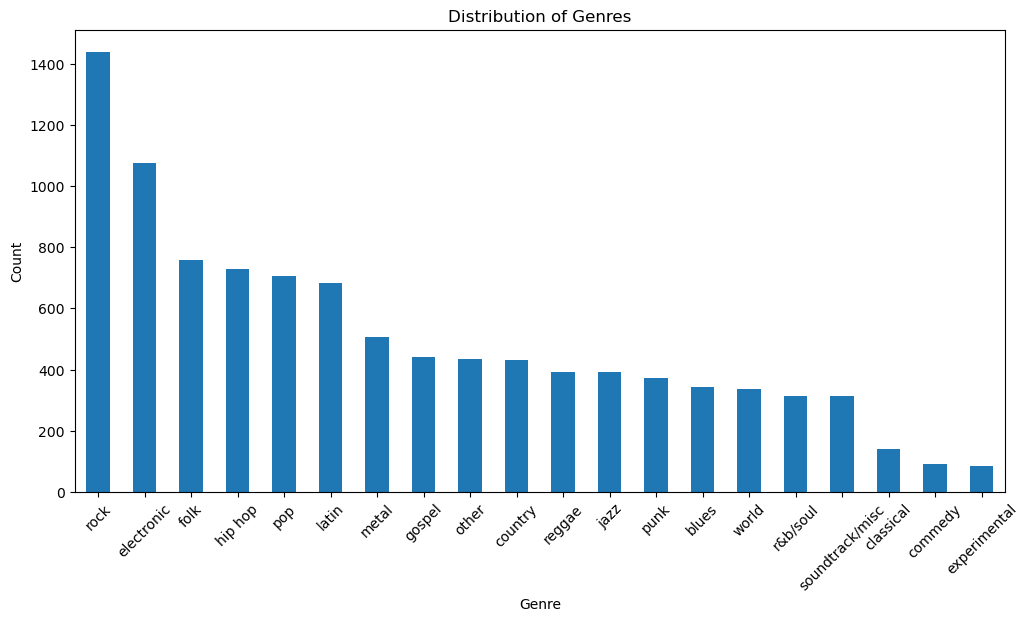

In [57]:
# Histogram of the target variable
plt.figure(figsize=(12, 6))
music['genre'].value_counts().plot(kind='bar')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Generate Train - Validate - Test Dataset

In [58]:
music.head(5)

,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,terms,genre,genre_encoded
0,0.643,0.58521,0.834,0.58521,218.93179,0.247,1.0,0.736,-11.197,0,0.636,218.932,0.779,0.28519,92.198,4.0,0.778,hip hop,hip hop,8
1,0.007,0.71054,1.000,0.20627,148.03546,0.148,6.0,0.169,-9.843,0,0.430,137.915,0.969,0.20627,121.274,4.0,0.384,blue-eyed soul,r&b/soul,15
2,0.980,0.73152,0.980,0.73152,177.47546,0.282,8.0,0.643,-9.689,1,0.565,172.304,0.482,0.42132,100.070,1.0,0.000,salsa,latin,10
3,0.017,1.30621,0.809,0.81002,233.40363,0.000,0.0,0.751,-9.013,1,0.749,217.124,0.601,0.56254,119.293,4.0,0.000,pop rock,pop,13
4,0.175,1.06368,0.883,0.13576,209.60608,0.066,2.0,0.092,-4.501,1,0.371,198.699,1.000,0.13576,129.738,4.0,0.562,pop punk,punk,14


Uncomment if needed

In [59]:
# dataset = music.drop(columns=['terms'])

# # train - validation - test: 80-10-10
# train_val_data, test_data = train_test_split(dataset, test_size=0.1, random_state=40)
# train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=40)

# train_data.to_csv('train_data.csv', index=False)
# val_data.to_csv('val_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

In [60]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")
val_data = pd.read_csv("val_data.csv")

X_train, y_train = train_data.drop(columns=['genre_encoded', 'genre']), train_data['genre_encoded']
X_test, y_test = test_data.drop(columns=['genre_encoded', 'genre']), test_data['genre_encoded']
X_val, y_val = val_data.drop(columns=['genre_encoded', 'genre']), val_data['genre_encoded']

### Logistic Regression (Baseline)

In [61]:
transformer = StandardScaler().fit(X_train)
X_train_norm = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)

# Apply the same transformation to the testing set
X_test_norm = transformer.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)

log_reg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_norm, y_train)
log_reg.predict_proba(X_test_norm)

array([[0.01787655, 0.01388531, 0.00580053, ..., 0.14687825, 0.03742975,
        0.03387521],
       [0.00838106, 0.00046429, 0.00616298, ..., 0.12890291, 0.00533164,
        0.0470113 ],
       [0.04374298, 0.00496117, 0.00674489, ..., 0.12254604, 0.04487344,
        0.04056871],
       ...,
       [0.03478006, 0.01007187, 0.00871403, ..., 0.14198603, 0.04140441,
        0.03296982],
       [0.02135058, 0.00239213, 0.00860148, ..., 0.16485589, 0.01239321,
        0.04111535],
       [0.0142631 , 0.05891978, 0.00865124, ..., 0.05101335, 0.1994074 ,
        0.01929365]], shape=(1000, 20))

---

In [62]:
# Make predictions
y_pred = log_reg.predict(X_test_norm)
y_proba = log_reg.predict_proba(X_test_norm)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.1700
Precision: 0.0976
Recall: 0.0999
F1 Score: 0.0859


In [63]:

# Top-k accuracy
top1 = top_k_accuracy_score(y_test, y_proba, k=1)  # Same as regular accuracy
top2 = top_k_accuracy_score(y_test, y_proba, k=2)


print(f"Top-1 Accuracy (regular): {top1:.4f}")
print(f"Top-2 Accuracy: {top2:.4f}")


Top-1 Accuracy (regular): 0.1700
Top-2 Accuracy: 0.3110


In [64]:
# Step 7: Print detailed classification report
print("Logistic Regression (Per-Class Report)")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

Logistic Regression (Per-Class Report)
                 precision    recall  f1-score   support

          blues       0.11      0.03      0.05        33
      classical       0.00      0.00      0.00        23
        commedy       0.00      0.00      0.00         6
        country       0.11      0.16      0.13        38
     electronic       0.20      0.31      0.24       110
   experimental       0.00      0.00      0.00         7
           folk       0.14      0.07      0.09        85
         gospel       0.00      0.00      0.00        53
        hip hop       0.22      0.29      0.25        73
           jazz       0.20      0.12      0.15        34
          latin       0.14      0.02      0.03        65
          metal       0.18      0.10      0.13        48
          other       0.00      0.00      0.00        47
            pop       0.00      0.00      0.00        71
           punk       0.39      0.27      0.32        44
       r&b/soul       0.00      0.00      0.00  

Accuracy: 0.17


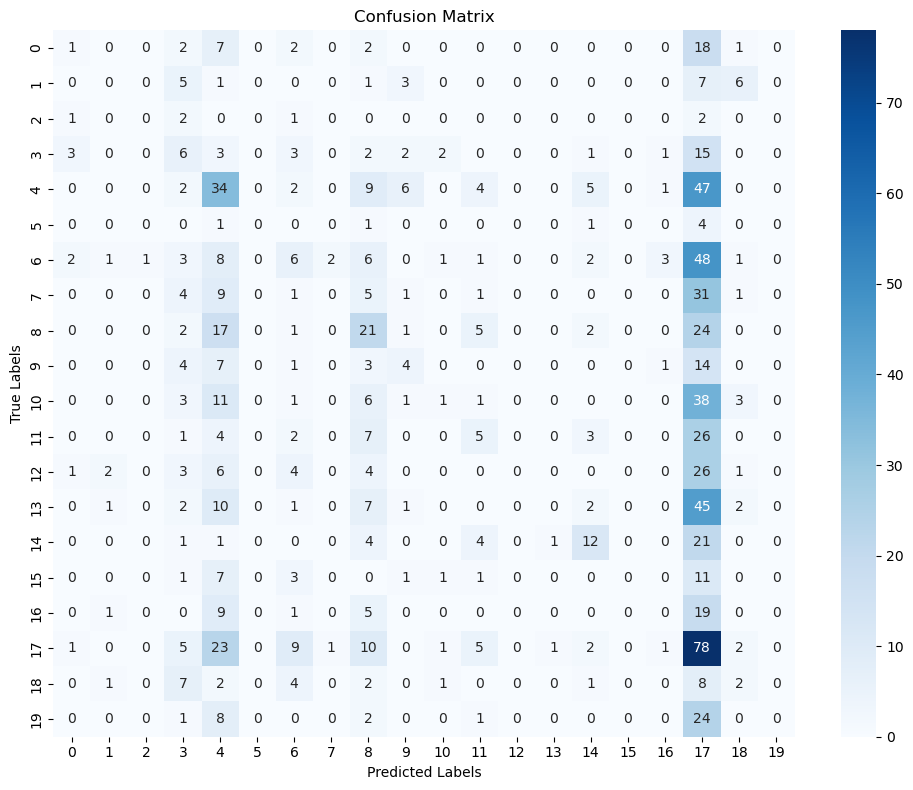

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.03      0.05        33
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00         6
           3       0.11      0.16      0.13        38
           4       0.20      0.31      0.24       110
           5       0.00      0.00      0.00         7
           6       0.14      0.07      0.09        85
           7       0.00      0.00      0.00        53
           8       0.22      0.29      0.25        73
           9       0.20      0.12      0.15        34
          10       0.14      0.02      0.03        65
          11       0.18      0.10      0.13        48
          12       0.00      0.00      0.00        47
          13       0.00      0.00      0.00        71
          14       0.39      0.27      0.32        44
          15       0.00      0.00      0.00        25
          16       0.00      0.00      0.00        35
    

In [65]:
y_pred = log_reg.predict(X_test_norm)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

class_report = classification_report(y_test, y_pred, zero_division=0)
print("Classification Report:")
print(class_report)


#### Graph Neural Networks

### Edges formed by labels directly (ground truth model)

In [66]:
all_genres = music['genre'].unique().tolist()

genre_to_idx = {g: i for i, g in enumerate(all_genres)}
num_genres = len(all_genres)

In [67]:
# SONG NODE

song_features = [
    'bars_confidence', 'bars_start', 'beats_confidence', 'beats_start',
    'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness',
    'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence',
    'tatums_start', 'tempo', 'time_signature', 'time_signature_confidence'
]

num_songs = len(music)
num_song_feats = len(song_features)
song_x = np.zeros((num_songs, num_song_feats), dtype=np.float32)

song_y_list = []

for i, (idx, row) in enumerate(music.iterrows()):
    song_x[i] = row[song_features].values

    genre_str = row['genre']
    label_idx = genre_to_idx[genre_str]
    song_y_list.append(label_idx)

song_x = torch.tensor(song_x, dtype=torch.float32)
song_y = torch.tensor(song_y_list, dtype=torch.long)


In [68]:
data = Data()

data.x = song_x
data.y = song_y

print(data)


Data(x=[9995, 17], y=[9995])


In [69]:
num_songs = data.x.size(0)

indices = np.arange(num_songs)
np.random.shuffle(indices)

train_size = int(0.7 * num_songs)
val_size   = int(0.15 * num_songs)
test_size  = num_songs - train_size - val_size

train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size+val_size]
test_idx  = indices[train_size+val_size:]

train_mask = torch.zeros(num_songs, dtype=torch.bool)
val_mask   = torch.zeros(num_songs, dtype=torch.bool)
test_mask  = torch.zeros(num_songs, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

data.train_mask = train_mask
data.val_mask   = val_mask
data.test_mask  = test_mask

In [70]:
def create_song_song_edges(song_y):
    edges = []
    for i in range(len(song_y)):
        genre_i = song_y[i].item()
        same_genre_indices = torch.where(song_y == genre_i)[0]
        if len(same_genre_indices) > 10:
            indices_to_connect = np.random.choice(
                same_genre_indices.cpu().numpy(), 
                size=10, 
                replace=False
            )
        else:
            indices_to_connect = same_genre_indices.cpu().numpy()
            
        for j in indices_to_connect:
            if i != j:
                edges.append([i, j])
                edges.append([j, i])  
    
    edge_index = torch.tensor(edges, dtype=torch.long).t()
    return edge_index

In [71]:
class SongData:
    def __init__(self, x, edge_index, y, train_mask, val_mask, test_mask):
        self.x = x
        self.edge_index = edge_index
        self.y = y
        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask

Epoch: 010, Loss: 25.7123, Train: 0.1411, Val: 0.1521, Test: 0.1493
Epoch: 020, Loss: 12.0209, Train: 0.1893, Val: 0.1928, Test: 0.1967
Epoch: 030, Loss: 6.4857, Train: 0.1797, Val: 0.1781, Test: 0.1900
Epoch: 040, Loss: 3.5174, Train: 0.3255, Val: 0.3302, Test: 0.3347
Epoch: 050, Loss: 2.4183, Train: 0.3372, Val: 0.3462, Test: 0.3487
Epoch: 060, Loss: 1.9922, Train: 0.4200, Val: 0.4283, Test: 0.4367
Epoch: 070, Loss: 1.8427, Train: 0.4488, Val: 0.4536, Test: 0.4493
Epoch: 080, Loss: 1.7120, Train: 0.5001, Val: 0.5137, Test: 0.4960
Epoch: 090, Loss: 1.6517, Train: 0.5572, Val: 0.5871, Test: 0.5553
Epoch: 100, Loss: 1.5054, Train: 0.5716, Val: 0.5964, Test: 0.5660
Epoch: 110, Loss: 1.4962, Train: 0.5803, Val: 0.6077, Test: 0.5780
Epoch: 120, Loss: 1.4257, Train: 0.5989, Val: 0.6244, Test: 0.6020
Epoch: 130, Loss: 1.3493, Train: 0.6820, Val: 0.7011, Test: 0.6787
Epoch: 140, Loss: 1.2331, Train: 0.7163, Val: 0.7272, Test: 0.7093
Epoch: 150, Loss: 1.2537, Train: 0.7406, Val: 0.7512, Test: 

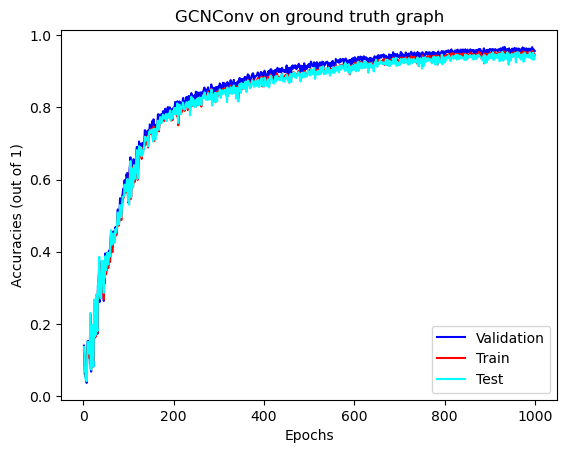

In [72]:
class SongOnlyGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

num_songs = song_x.size(0)
song_edge_index = create_song_song_edges(song_y)

song_data = SongData(
    x=song_x.to(device),
    edge_index=song_edge_index.to(device),
    y=song_y.to(device),
    train_mask=train_mask.to(device),
    val_mask=val_mask.to(device),
    test_mask=test_mask.to(device)
)

num_classes = song_y.max().item() + 1
model = SongOnlyGCN(
    in_channels=song_x.size(1),
    hidden_channels=64,
    out_channels=num_classes,
    dropout=0.5
).to(device)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(song_data.x, song_data.edge_index)
    loss = F.cross_entropy(out[song_data.train_mask], song_data.y[song_data.train_mask])
    loss.backward()
    optimizer.step()
    
    return float(loss)

@torch.no_grad()
def evaluate(mask_type='val'):
    model.eval()
    out = model(song_data.x, song_data.edge_index)

    if mask_type == 'train':
        mask = song_data.train_mask
    elif mask_type == 'val':
        mask = song_data.val_mask
    else:
        mask = song_data.test_mask
    
    pred = out[mask].argmax(dim=1)
    correct = pred.eq(song_data.y[mask]).sum().item()
    total = mask.sum().item()
    
    return correct / total

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

epochs = 1000
best_val_acc = 0
best_model = None
patience = 500
patience_counter = 0
train_losses = []
train_accs = []
val_accs = []
test_accs = []
epoch_l = []

for epoch in range(1, epochs + 1):
    loss = train()
    train_losses.append(loss)
    
    train_acc = evaluate('train')
    val_acc = evaluate('val')
    test_acc = evaluate('test')
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    epoch_l.append(epoch)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

if best_model is not None:
    model.load_state_dict(best_model)
    print("\nFinal Results:")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Test Accuracy: {evaluate('test'):.4f}")
    
plt.plot(epoch_l, val_accs, color = 'blue', label='Validation')
plt.plot(epoch_l, train_accs, color = 'red', label='Train')
plt.plot(epoch_l, test_accs, color = 'cyan', label= 'Test')
plt.title("GCNConv on ground truth graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracies (out of 1)")

plt.legend()
plt.show()

---

### KNN Graph, edges based on features

In [73]:
X.drop("terms", axis=1, inplace=True)

In [74]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X.values)
X_ts = torch.tensor(X_norm, dtype=torch.float)
y_ts = torch.tensor(y, dtype=torch.long)

In [75]:
k = 10
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm="auto").fit(X.values)
distances, indices = nbrs.kneighbors(X.values)

edge_list = []

num_nodes = X_ts.size(0)
for i in range(num_nodes):
    for j in indices[i, 1:]:
        edge_list.append((i, j))

edge_list += [(j, i) for i, j in edge_list]

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

In [76]:
music_graph = Data(x=X_ts, edge_index=edge_index, y=y_ts)

In [77]:
music_graph

Data(x=[9995, 17], edge_index=[2, 199900], y=[9995])

In [78]:
num_nodes = music_graph.num_nodes

import numpy as np
indices = np.random.permutation(num_nodes)
train_size = int(0.7 * num_nodes)
val_size = int(0.15 * num_nodes)

train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size + val_size]
test_idx  = indices[train_size + val_size:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

music_graph.train_mask = train_mask.to(device)
music_graph.val_mask   = val_mask.to(device)
music_graph.test_mask  = test_mask.to(device)

In [79]:
music_graph

Data(x=[9995, 17], edge_index=[2, 199900], y=[9995], train_mask=[9995], val_mask=[9995], test_mask=[9995])

In [80]:
music_graph=music_graph.to(device)

In [81]:
# Display graph
music_G = to_networkx(music_graph, to_undirected=True)
sub_nodes = list(range(2000))
music_subG = music_G.subgraph(sub_nodes)

net = Network(height="800px", width="100%")
net.show_buttons(filter_=['physics'])
net.from_nx(music_subG)

net.write_html("music_graph.html", open_browser=True, notebook=False)

Epoch: 010, Loss: 2.7344, Train: 0.1564, Val: 0.1614, Test: 0.1693
Epoch: 020, Loss: 2.6659, Train: 0.1768, Val: 0.1648, Test: 0.1780
Epoch: 030, Loss: 2.6397, Train: 0.1810, Val: 0.1741, Test: 0.1767
Epoch: 040, Loss: 2.6265, Train: 0.1858, Val: 0.1855, Test: 0.1773
Epoch: 050, Loss: 2.6177, Train: 0.1860, Val: 0.1788, Test: 0.1773
Epoch: 060, Loss: 2.6084, Train: 0.1884, Val: 0.1815, Test: 0.1733
Epoch: 070, Loss: 2.6063, Train: 0.1895, Val: 0.1781, Test: 0.1740
Epoch: 080, Loss: 2.6029, Train: 0.1893, Val: 0.1808, Test: 0.1773
Epoch: 090, Loss: 2.5958, Train: 0.1915, Val: 0.1808, Test: 0.1747
Epoch: 100, Loss: 2.5962, Train: 0.1920, Val: 0.1821, Test: 0.1773
Epoch: 110, Loss: 2.5892, Train: 0.1940, Val: 0.1855, Test: 0.1760
Epoch: 120, Loss: 2.5877, Train: 0.1958, Val: 0.1841, Test: 0.1773
Epoch: 130, Loss: 2.5823, Train: 0.1944, Val: 0.1828, Test: 0.1767
Epoch: 140, Loss: 2.5843, Train: 0.1930, Val: 0.1821, Test: 0.1760
Epoch: 150, Loss: 2.5791, Train: 0.1958, Val: 0.1815, Test: 0.

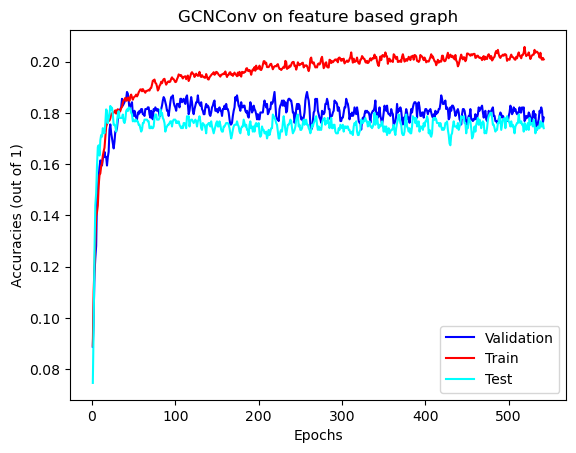

In [ ]:
num_classes = music_graph.y.max().item() + 1
model = SongOnlyGCN(
    in_channels=music_graph.x.size(1),
    hidden_channels=64,
    out_channels=num_classes,
    dropout=0.5
).to(device)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(music_graph.x, music_graph.edge_index)
    loss = F.cross_entropy(out[music_graph.train_mask], music_graph.y[music_graph.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def evaluate(mask_type='val'):
    model.eval()
    out = model(music_graph.x, music_graph.edge_index)
    
    if mask_type == 'train':
        mask = music_graph.train_mask
    elif mask_type == 'val':
        mask = music_graph.val_mask
    else:
        mask = music_graph.test_mask
        
    pred = out[mask].argmax(dim=1)
    correct = pred.eq(music_graph.y[mask]).sum().item()
    total = mask.sum().item()
    return correct / total

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

epochs = 1000
best_val_acc = 0
best_model = None
patience = 500
patience_counter = 0
train_losses = []
train_accs = []
val_accs = []
test_accs = []
epoch_l = []

for epoch in range(1, epochs + 1):
    loss = train()
    train_losses.append(loss)
    
    train_acc = evaluate('train')
    val_acc = evaluate('val')
    test_acc = evaluate('test')
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    epoch_l.append(epoch)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

if best_model is not None:
    model.load_state_dict(best_model)
    print("\nFinal Results:")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Test Accuracy: {evaluate('test'):.4f}")
    
plt.plot(epoch_l, val_accs, color = 'blue', label='Validation')
plt.plot(epoch_l, train_accs, color = 'red', label='Train')
plt.plot(epoch_l, test_accs, color = 'cyan', label= 'Test')
plt.title("GCNConv on feature based graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracies (out of 1)")

plt.legend()
plt.show()

---